<a href="https://colab.research.google.com/github/mariajmolina/UMDAOSC650/blob/main/autoencoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [34]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import keras
from keras import layers
import tensorflow as tf

In [2]:
# Set the seed using keras.utils.set_random_seed. This will set:
# 1) `numpy` seed
# 2) backend random seed
# 3) `python` random seed
keras.utils.set_random_seed(812)

In [3]:
! wget https://zenodo.org/records/10576726/files/current_SP3hourly_20110427.nc

--2025-04-08 16:03:54--  https://zenodo.org/records/10576726/files/current_SP3hourly_20110427.nc
Resolving zenodo.org (zenodo.org)... 188.185.48.194, 188.185.45.92, 188.185.43.25, ...
Connecting to zenodo.org (zenodo.org)|188.185.48.194|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 109400556 (104M) [application/octet-stream]
Saving to: ‘current_SP3hourly_20110427.nc’

current_SP3hourly_2 100%[===================>] 104.33M  21.0MB/s    in 12s     

2025-04-08 16:04:06 (9.02 MB/s) - ‘current_SP3hourly_20110427.nc’ saved [109400556/109400556]



In [4]:
# import dataset (netcdf)
ds = xr.open_dataset('current_SP3hourly_20110427.nc')

In [5]:
ds

<xarray.Dataset> Size: 109MB
Dimensions:      (starttime: 2224, y: 32, x: 32)
Coordinates:
  * starttime    (starttime) float64 18kB 9.264e+04 9.264e+04 ... 9.266e+04
    endtime      (starttime) float64 18kB ...
    x_speed      (starttime) int64 18kB ...
    y_speed      (starttime) int64 18kB ...
Dimensions without coordinates: y, x
Data variables:
    uh25_grid    (starttime, y, x) float32 9MB ...
    uh03_grid    (starttime, y, x) float32 9MB ...
    ctt_grid     (starttime, y, x) float32 9MB ...
    dbz_grid     (starttime, y, x) float32 9MB ...
    mask         (starttime, y, x) int64 18MB ...
    row_indices  (starttime, y, x) int64 18MB ...
    col_indices  (starttime, y, x) int64 18MB ...
    lats         (starttime, y, x) float32 9MB ...
    lons         (starttime, y, x) float32 9MB ...

## ANN Autoencoder

We will again use the previous data, but this time we will focus on reconstructing one input variable (feature).

In [6]:
# selecting a variable
ds['dbz_grid']

<xarray.DataArray 'dbz_grid' (starttime: 2224, y: 32, x: 32)> Size: 9MB
[2277376 values with dtype=float32]
Coordinates:
  * starttime  (starttime) float64 18kB 9.264e+04 9.264e+04 ... 9.266e+04
    endtime    (starttime) float64 18kB ...
    x_speed    (starttime) int64 18kB ...
    y_speed    (starttime) int64 18kB ...
Dimensions without coordinates: y, x

In [7]:
# reshape data to be samples, features
features_data = ds['dbz_grid'].stack(new_dim=(["y", "x"])).values
print(features_data.shape)

(2224, 1024)


In [9]:
features_data.shape

(2224, 1024)

In [10]:
# split dataset into training and testing set
X_train, X_test, y_train, y_test = train_test_split(
    features_data,
    features_data,
    test_size=0.3,
    shuffle=False,
    random_state=42)

In [11]:
# now rescale your data
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train) # input
X_test = scaler.transform(X_test) # input
y_train = scaler.transform(y_train) # label
y_test = scaler.transform(y_test) # label

In [12]:
# check shapes
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(1556, 1024) (668, 1024) (1556, 1024) (668, 1024)


## A simple autoencoder can be constructed as typical NNs, by adding sequential layers:

In [16]:
# create fully connected autoencoder
model = keras.Sequential()

# input
model.add(keras.Input(shape=(1024,))) # features

# encoder
# hidden layers
model.add(layers.Dense(32, activation="relu"))
model.add(layers.Dense(8, activation="relu"))

# desired dimensions
model.add(layers.Dense(2, activation="relu"))

# decoder
model.add(layers.Dense(8, activation="relu"))
model.add(layers.Dense(32, activation="relu"))

# Finally, we add last layer
model.add(layers.Dense(1024, activation='linear')) # back to the original shape

# print model summary
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 32)                  │          32,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 8)                   │             264 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 2)                   │              18 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 8)                   │              24 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 32)                  │             288 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 1024)                │          33,792 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 67,186 (262.45 KB)

 Trainable params: 67,186 (262.45 KB)

 Non-trainable params: 0 (0.00 B)

In [17]:
# define list of metrics
METRICS = [
    keras.metrics.MeanSquaredError(name='mean_squared_error'),
    keras.metrics.RootMeanSquaredError(name='root_mean_squared_error'),
    keras.metrics.MeanAbsoluteError(name='mean_absolute_error'),
    keras.metrics.MeanAbsolutePercentageError(name="mean_absolute_percentage_error"),
    keras.metrics.R2Score()
]

# compile your nn
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss="mean_squared_error",
    metrics=METRICS
)

# set hyperparameters
BATCH_SIZE = 32
EPOCHS = 10

In [18]:
# train the NN now
history = model.fit(
    x=X_train,
    y=y_train,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_split=0.1,
    shuffle=True,
)

Epoch 1/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 8s 66ms/step - loss: 0.8879 - mean_absolute_error: 0.7422 - mean_absolute_percentage_error: 424.9009 - mean_squared_error: 0.8879 - r2_score: 0.0847 - root_mean_squared_error: 0.9417 - val_loss: 0.7432 - val_mean_absolute_error: 0.7084 - val_mean_absolute_percentage_error: 222.2127 - val_mean_squared_error: 0.7432 - val_r2_score: 0.2861 - val_root_mean_squared_error: 0.8621
Epoch 2/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - loss: 0.6861 - mean_absolute_error: 0.6727 - mean_absolute_percentage_error: 660.0444 - mean_squared_error: 0.6861 - r2_score: 0.2912 - root_mean_squared_error: 0.8283 - val_loss: 0.7095 - val_mean_absolute_error: 0.6878 - val_mean_absolute_percentage_error: 251.3514 - val_mean_squared_error: 0.7095 - val_r2_score: 0.3200 - val_root_mean_squared_error: 0.8423
Epoch 3/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.6510 - mean_absolute_error: 0.6475 - mean_absolute_percentage_error: 671.1599 - mean_squared_error: 0.6510 - 

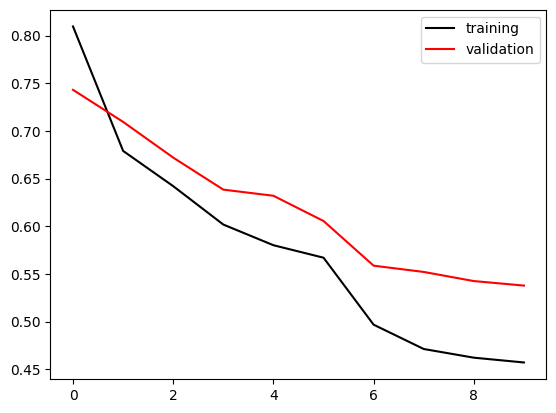

In [19]:
# visualize training and validation curves
plt.plot(history.history["mean_squared_error"], c='k', label='training')
plt.plot(history.history["val_mean_squared_error"], c='r', label='validation')
plt.legend()
plt.show()

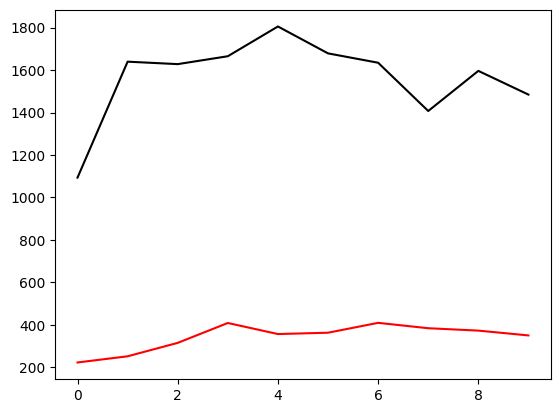

In [20]:
# visualize training and validation curves
plt.plot(history.history["mean_absolute_percentage_error"], c='k')
plt.plot(history.history["val_mean_absolute_percentage_error"], c='r')
plt.show()

In [21]:
# evaluation mode
y_pred = model.predict(X_test)

21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step


In [22]:
# check prediction shape matches test data shape
y_pred.shape

(668, 1024)

In [23]:
y_test.shape

(668, 1024)

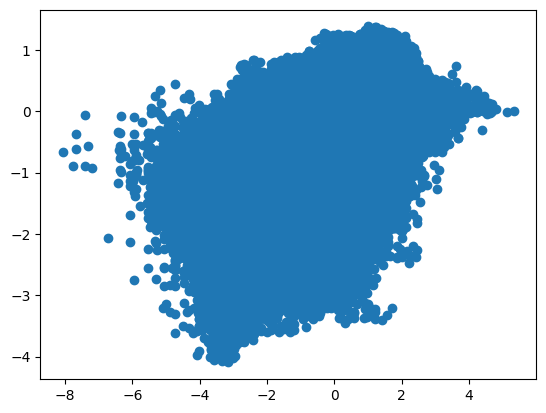

In [24]:
# visualize obs (x-axis) to nn predictions (y-axis)
plt.scatter(y_test, y_pred)
plt.show()

In [25]:
# evaluations (MSE)
mean_squared_error(y_test, y_pred)

0.7701334953308105

In [26]:
# to extract model layers, we can first print out model summary
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 32)                  │          32,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 8)                   │             264 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 2)                   │              18 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 8)                   │              24 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 32)                  │             288 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 1024)                │          33,792 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 201,560 (787.35 KB)

 Trainable params: 67,186 (262.45 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 134,374 (524.90 KB)

In [27]:
# model layers are contained as a list
model.layers

[<Dense name=dense, built=True>,
 <Dense name=dense_1, built=True>,
 <Dense name=dense_2, built=True>,
 <Dense name=dense_3, built=True>,
 <Dense name=dense_4, built=True>,
 <Dense name=dense_5, built=True>]

In [28]:
# lets select the first layer
model.layers[0].input

<KerasTensor shape=(None, 1024), dtype=float32, sparse=False, name=keras_tensor>

In [29]:
# and the bottleneck layer
model.layers[1].output

<KerasTensor shape=(None, 8), dtype=float32, sparse=False, name=keras_tensor_3>

In [53]:
# we define the input layer to the ANN and the output of the bottleneck layer
bottleneck = tf.keras.Model(
    inputs=model.layers[0].input,
    outputs=model.layers[2].output
    )

In [54]:
# input test data into the bottleneck function
bottleneck_output = bottleneck(X_test)

In [55]:
X_test.shape

(668, 1024)

In [56]:
bottleneck_output.shape

TensorShape([668, 2])

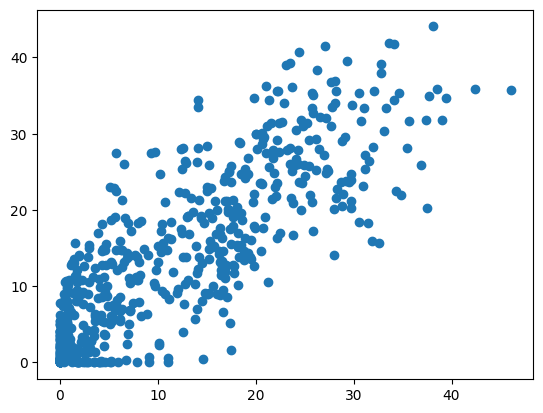

In [58]:
# we can visualize what these two nodes in the bottleneck output
plt.scatter(bottleneck_output[:,0],bottleneck_output[:,1])
plt.show()

In [62]:
# saving model
model.save('autoencodersample.keras')

In [63]:
# loading model
model2 = keras.models.load_model('autoencodersample.keras')

In [64]:
# inference with loaded model
ypred2 = model2.predict(X_test)

21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step


We can use autoencoders for the task of anomaly detection. For anomaly detection, we would note instances where reconstruction error for an image is higher, indicating that the sample was likely not similar to those in the training set distribution.

The prediction loss threshold for 2% of outliers is 1.14


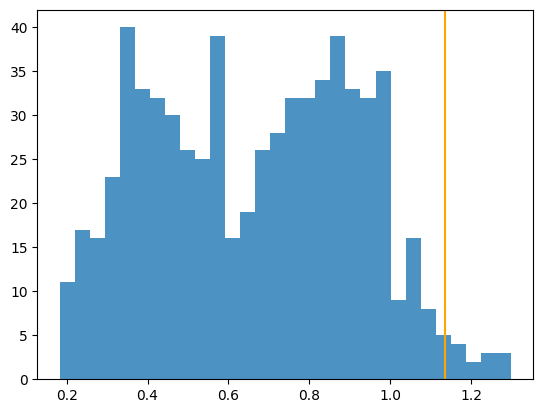

In [68]:
# for get the mean absolute error between actual and reconstruction/prediction
#prediction_loss = keras.losses.mae(ypred2, y_test)
MAE = keras.losses.MeanAbsoluteError(
    reduction=tf.keras.losses.Reduction.NONE,
    name="mean_absolute_error",
    dtype=None
)
prediction_loss = MAE(ypred2, y_test)

# for check the prediction loss threshold for 2% of outliers
loss_threshold = np.percentile(prediction_loss, 98)

print(f'The prediction loss threshold for 2% of outliers is {loss_threshold:.2f}')
# for visualize the threshold
plt.hist(prediction_loss, bins=30, alpha=0.8)
plt.axvline(x=loss_threshold, color='orange')
plt.show()

The prediction loss threshold for 2% of outliers is 21.88


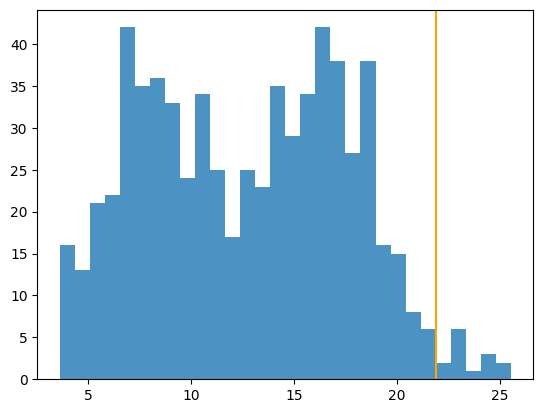

In [69]:
# same as above but for inverse transformed data
# for get the mean absolute error between actual and reconstruction/prediction
rescaled_pred = scaler.inverse_transform(ypred2)
rescaled_test = scaler.inverse_transform(X_test)

prediction_loss = MAE(rescaled_pred, rescaled_test)

# for check the prediction loss threshold for 2% of outliers
loss_threshold = np.percentile(prediction_loss, 98)

print(f'The prediction loss threshold for 2% of outliers is {loss_threshold:.2f}')
# for visualize the threshold
plt.hist(prediction_loss, bins=30, alpha=0.8)
plt.axvline(x=loss_threshold, color='orange')
plt.show()

## CNN Autoencoder

In [70]:
def z_score(da):
    """
    Compute z-score for training data.
    Normalizing data for ML model training.
    Args:
        da (array): Array of training variable.
    """
    return (da - np.mean(da)) / np.std(da)

def z_score_testing(da, testdata):
    """
    Compute z-score for testing data.
    Args:
        da (array): Array of training variable.
    """
    return (testdata - np.mean(da)) / np.std(da)

In [71]:
# reshape data to be samples, features
features_data = ds['dbz_grid'].values
print(features_data.shape)

(2224, 32, 32)


In [74]:
X_train, X_test, y_train, y_test = features_data[:1800], features_data[1800:], features_data[:1800], features_data[1800:]

In [75]:
X_test = z_score_testing(X_train, X_test) # input
y_test = z_score_testing(y_train, y_test) # label

X_train = z_score(X_train) # input
y_train = z_score(y_train) # label

In [76]:
# check shapes
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(1800, 32, 32) (424, 32, 32) (1800, 32, 32) (424, 32, 32)


In [77]:
model = keras.Sequential()

# input
model.add(keras.Input(shape=(32, 32, 1)))  # 32x32 images

# encoder
# hidden layers
model.add(layers.Conv2D(16, 3, strides=1, padding="same", activation="relu"))
model.add(layers.MaxPooling2D(2))

model.add(layers.Conv2D(8, 3, strides=1, padding="same", activation="relu"))
model.add(layers.MaxPooling2D(2))

model.add(layers.Conv2D(4, 3, strides=1, padding="same", activation="relu"))
model.add(layers.MaxPooling2D(2))

# decoder
model.add(layers.Conv2D(4, 3, strides=1, padding="same", activation="relu"))
model.add(layers.UpSampling2D(2))

model.add(layers.Conv2D(8, 3, strides=1, padding="same", activation="relu"))
model.add(layers.UpSampling2D(2))

model.add(layers.Conv2D(16, 3, strides=1, padding="same", activation="relu"))
model.add(layers.UpSampling2D(2))

# Finally, we add last layer
model.add(layers.Conv2D(1, (3, 3), activation='linear', padding='same'))

# print model summary
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 32, 32, 16)          │             160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 16, 16, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 16, 16, 8)           │           1,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 8, 8, 8)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 8, 8, 4)             │             292 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 4, 4, 4)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 4, 4, 4)             │             148 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling2d (UpSampling2D)         │ (None, 8, 8, 4)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 8, 8, 8)             │             296 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling2d_1 (UpSampling2D)       │ (None, 16, 16, 8)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 16, 16, 16)          │           1,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling2d_2 (UpSampling2D)       │ (None, 32, 32, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 32, 32, 1)           │             145 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,369 (13.16 KB)

 Trainable params: 3,369 (13.16 KB)

 Non-trainable params: 0 (0.00 B)

In [78]:
METRICS = [
    keras.metrics.MeanSquaredError(name='mean_squared_error'),
    keras.metrics.RootMeanSquaredError(name='root_mean_squared_error'),
]

model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss="mean_squared_error",
    metrics=METRICS
)

BATCH_SIZE = 32
EPOCHS = 10

In [79]:
history = model.fit(
    x=X_train,
    y=y_train,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_split=0.1,
    shuffle=True,
)

Epoch 1/10
51/51 ━━━━━━━━━━━━━━━━━━━━ 9s 103ms/step - loss: 0.8539 - mean_squared_error: 0.8539 - root_mean_squared_error: 0.9233 - val_loss: 0.5630 - val_mean_squared_error: 0.5630 - val_root_mean_squared_error: 0.7504
Epoch 2/10
51/51 ━━━━━━━━━━━━━━━━━━━━ 10s 103ms/step - loss: 0.3734 - mean_squared_error: 0.3734 - root_mean_squared_error: 0.6109 - val_loss: 0.4186 - val_mean_squared_error: 0.4186 - val_root_mean_squared_error: 0.6470
Epoch 3/10
51/51 ━━━━━━━━━━━━━━━━━━━━ 7s 47ms/step - loss: 0.2820 - mean_squared_error: 0.2820 - root_mean_squared_error: 0.5310 - val_loss: 0.3661 - val_mean_squared_error: 0.3661 - val_root_mean_squared_error: 0.6050
Epoch 4/10
51/51 ━━━━━━━━━━━━━━━━━━━━ 3s 57ms/step - loss: 0.2414 - mean_squared_error: 0.2414 - root_mean_squared_error: 0.4913 - val_loss: 0.3353 - val_mean_squared_error: 0.3353 - val_root_mean_squared_error: 0.5790
Epoch 5/10
51/51 ━━━━━━━━━━━━━━━━━━━━ 5s 47ms/step - loss: 0.2169 - mean_squared_error: 0.2169 - root_mean_squared_error:

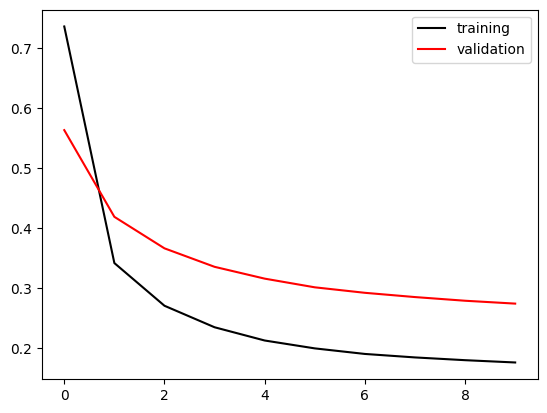

In [80]:
plt.plot(history.history["mean_squared_error"], c='k', label='training')
plt.plot(history.history["val_mean_squared_error"], c='r', label='validation')
plt.legend()
plt.show()

In [81]:
# saving model
model.save('autoencodercnn.keras')

# loading model
model2 = keras.models.load_model('autoencodercnn.keras')

In [82]:
# inference with loaded model
ypred2 = model2.predict(X_test)

14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step


In [83]:
print(y_test.shape, ypred2[:,:,:,0].shape)

(424, 32, 32) (424, 32, 32)


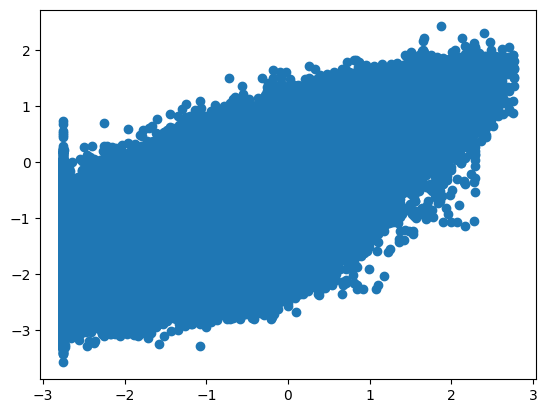

In [84]:
# evaluations
plt.scatter(np.ndarray.flatten(y_test), np.ndarray.flatten(ypred2[:,:,:,0]))
plt.show()

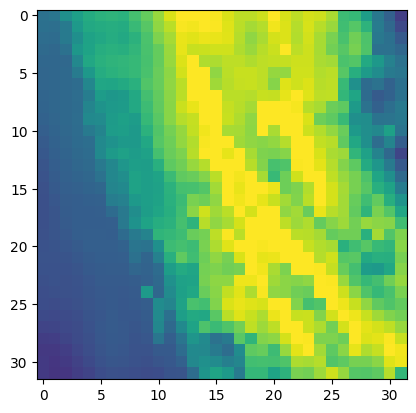

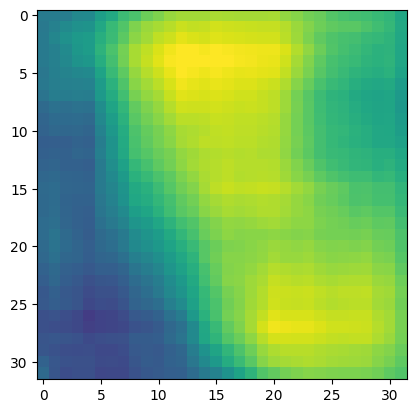

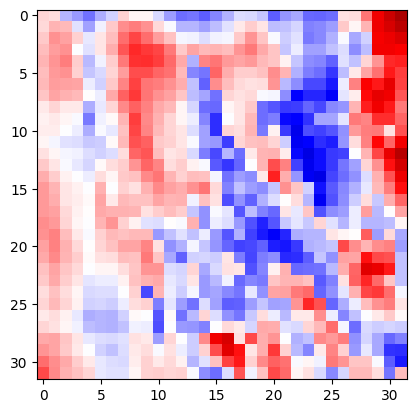

In [85]:
# evaluations
sample_indx = 15

plt.imshow(y_test[sample_indx,:,:], vmin=-1, vmax=1)
plt.show()

plt.imshow(ypred2[sample_indx,:,:,0], vmin=-1, vmax=1)
plt.show()

plt.imshow(ypred2[sample_indx,:,:,0] - y_test[sample_indx,:,:], cmap='seismic', vmin=-1, vmax=1)
plt.show()

In [86]:
# evaluations (MSE)
mean_squared_error(np.ndarray.flatten(y_test), np.ndarray.flatten(ypred2[:,:,:,0]))

0.3629337549209595

## CNN Autoencoder Noise Removal

In [87]:
def noise(array):
    """Adds random noise to each image in the supplied array."""
    noise_factor = 0.4
    noisy_array = array + noise_factor * np.random.normal(
        loc=0.0, scale=1.0, size=array.shape
    )
    return noisy_array

In [88]:
# reshape data to be samples, features
features_data = ds['dbz_grid'].values
print(features_data.shape)

X_train, X_test, y_train, y_test = features_data[:1800], features_data[1800:], features_data[:1800], features_data[1800:]

X_test = z_score_testing(X_train, X_test) # input
y_test = z_score_testing(y_train, y_test) # label

X_train = z_score(X_train) # input
y_train = z_score(y_train) # label

# check shapes
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(2224, 32, 32)
(1800, 32, 32) (424, 32, 32) (1800, 32, 32) (424, 32, 32)


In [89]:
# Create a copy of the data with added noise
noisy_train_data = noise(X_train)
noisy_test_data = noise(X_test)

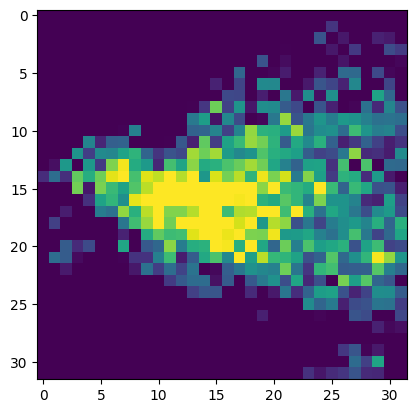

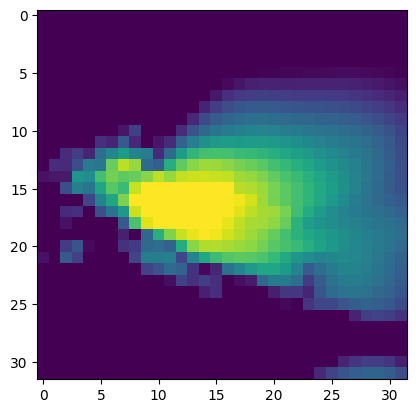

In [90]:
plt.imshow(noisy_train_data[0,:,:], vmin=-1, vmax=1)
plt.show()

plt.imshow(X_train[0,:,:], vmin=-1, vmax=1)
plt.show()

In [91]:
# loading model
model_transfer = keras.models.load_model('autoencodercnn.keras')

In [92]:
model_transfer

<Sequential name=sequential_2, built=True>

In [93]:
history = model_transfer.fit(
    x=noisy_train_data,
    y=y_train,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_split=0.1,
    shuffle=True,
)

Epoch 1/10
51/51 ━━━━━━━━━━━━━━━━━━━━ 5s 76ms/step - loss: 0.1794 - mean_squared_error: 0.1794 - root_mean_squared_error: 0.4235 - val_loss: 0.2738 - val_mean_squared_error: 0.2738 - val_root_mean_squared_error: 0.5232
Epoch 2/10
51/51 ━━━━━━━━━━━━━━━━━━━━ 5s 91ms/step - loss: 0.1737 - mean_squared_error: 0.1737 - root_mean_squared_error: 0.4167 - val_loss: 0.2696 - val_mean_squared_error: 0.2696 - val_root_mean_squared_error: 0.5192
Epoch 3/10
51/51 ━━━━━━━━━━━━━━━━━━━━ 5s 88ms/step - loss: 0.1706 - mean_squared_error: 0.1706 - root_mean_squared_error: 0.4130 - val_loss: 0.2652 - val_mean_squared_error: 0.2652 - val_root_mean_squared_error: 0.5149
Epoch 4/10
51/51 ━━━━━━━━━━━━━━━━━━━━ 5s 103ms/step - loss: 0.1676 - mean_squared_error: 0.1676 - root_mean_squared_error: 0.4093 - val_loss: 0.2611 - val_mean_squared_error: 0.2611 - val_root_mean_squared_error: 0.5110
Epoch 5/10
51/51 ━━━━━━━━━━━━━━━━━━━━ 7s 45ms/step - loss: 0.1646 - mean_squared_error: 0.1646 - root_mean_squared_error: 0

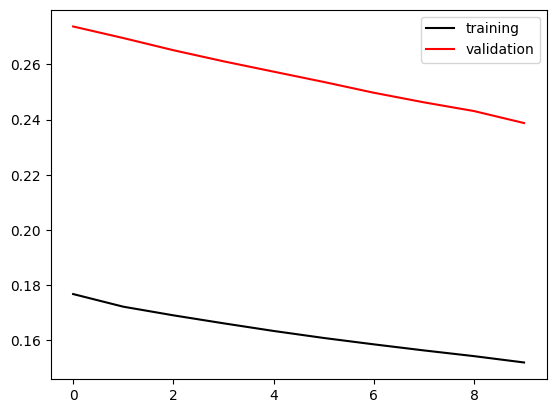

In [94]:
plt.plot(history.history["mean_squared_error"], c='k', label='training')
plt.plot(history.history["val_mean_squared_error"], c='r', label='validation')
plt.legend()
plt.show()

In [95]:
# inference with model
ypred = model_transfer.predict(noisy_test_data)

14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step


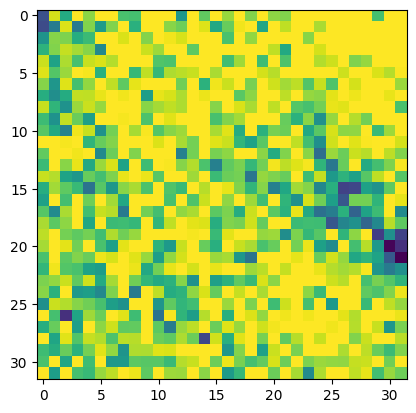

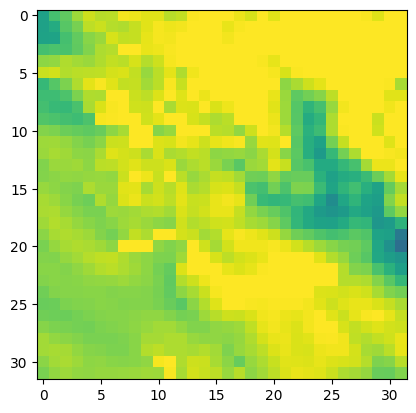

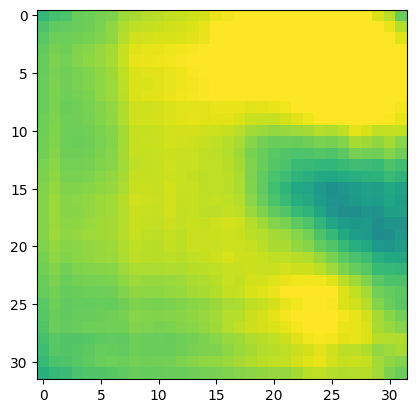

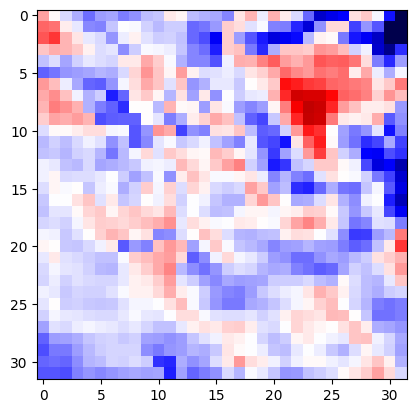

In [96]:
# evaluations
sample_indx = 42

plt.imshow(noisy_test_data[sample_indx, :, :], vmin=-1, vmax=1)
plt.show()

plt.imshow(y_test[sample_indx,:,:], vmin=-1, vmax=1)
plt.show()

plt.imshow(ypred[sample_indx,:,:,0], vmin=-1, vmax=1)
plt.show()

plt.imshow(ypred[sample_indx,:,:,0] - y_test[sample_indx,:,:], cmap='seismic', vmin=-1, vmax=1)
plt.show()